In [50]:
# Import packages

from keras.preprocessing import image
from keras.layers import (
    GlobalAveragePooling2D, Multiply, Flatten,
     Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D,
    Input, Lambda)
from keras.layers.experimental.preprocessing import Resizing
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras import Sequential, Model
from keras.applications import ResNet50

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from seaborn import heatmap
import matplotlib.pyplot as plt

In [3]:
# Change working directory
import os
os.chdir("/kaggle/input/")

In [4]:
# Load datasets
baseDirName = "techlabs-wtsa/"

trainData = pd.read_csv(baseDirName+"data_final.csv")

In [5]:
len(trainData["id"])

573

In [6]:
datagen = ImageDataGenerator(
    rescale = 1./255
    # We won't be using a validation set since every image is a category
)

In [7]:
datagen.fill_mode = 'nearest'
datagen.vertical_flip = True
datagen.horizontal_flip = True
datagen.width_shift_range = 0.2
datagen.height_shift_range = 0.2
datagen.rotation_range = 10
datagen.shear_range = 10
datagen.brightness_range = [0.65, 1.5]

In [8]:
trainData["imageName"] = [str(image) + ".jpg" for image in trainData["id"]]
trainData["idTarget"] = np.reshape(trainData["id"].to_numpy(),(-1,)) #Seems useless but the target needs to be reshaped


In [9]:
trainData.head(5)

,id,href,location_lat,location_lng,location_address,title,cityName,cityCountry,cityCountryShort,artistsString,...,images_2_sizes_large,images_2_sizes_orig,images_3_url,images_3_sizes_small,images_3_sizes_medium,images_3_sizes_large,images_3_sizes_orig,source,imageName,idTarget
0,0,https://berlin.streetartcities.com/artworks/to...,52.532920,13.483000,"Landsberger Allee 228B, Berlin, Deutschland",Totem,Berlin,Germany,DE,James Bullough and Addison Karl former aka JBA...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sac,0.jpg,0
1,1,https://berlin.streetartcities.com/artworks/un...,52.576876,13.276901,"Neheimer Str. 8, 13507 Berlin, Deutschland",Untitled,Berlin,Germany,DE,The London Police,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sac,1.jpg,1
2,2,https://berlin.streetartcities.com/artworks/un...,52.576144,13.272566,"Bernauer Str. 133, 13507 Berlin, Deutschland",Untitled,Berlin,Germany,DE,Fintan Magee,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sac,2.jpg,2
3,3,https://berlin.streetartcities.com/artworks/un...,52.576589,13.272580,"Neheimer Str. 13, 13507 Berlin, Deutschland",Untitled,Berlin,Germany,DE,Pixel Pancho,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sac,3.jpg,3
4,4,https://berlin.streetartcities.com/artworks/li...,52.498905,13.358139,"Bülowstraße 96, 10783 Berlin, Deutschland",Lilli and Hobbes,Berlin,Germany,DE,"ArtOfBust, Bustart, Bust",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sac,4.jpg,4


In [10]:
train_gen = datagen.flow_from_dataframe(trainData,
                                        directory = baseDirName + "images/",
                                        target_size = (224,224),
                                        x_col = "imageName",
                                        y_col = "idTarget",
                                        class_mode = 'raw',
                                        shuffle = True)

Found 573 validated image filenames.


Model training

In [11]:
resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

94773248/94765736 [==============================] - 1s 0us/step


In [12]:
for layer in resnet50.layers:
    layer.trainable = False

In [13]:
res_model = Sequential()
res_model.add(Input((256, 256, 3)))
res_model.add(Resizing(224, 224))
res_model.add(Lambda(lambda image: preprocess_input(image)))
res_model.add(resnet50)
res_model.add(Flatten())
res_model.add(Dense(573, activation = "softmax"))

In [14]:
res_model.compile(optimizer='adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
res_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 573)               57502269  
Total params: 81,089,981
Trainable params: 57,502,269
Non-trainable params: 23,587,712
_________________________________________________________________


In [15]:
history = res_model.fit(train_gen, 
                        epochs = 20,
                        verbose = 1,
                        callbacks=EarlyStopping(patience = 3))

Epoch 1/20
18/18 [==============================] - 18s 676ms/step - loss: 29.1987 - accuracy: 0.0000e+00
Epoch 2/20
18/18 [==============================] - 11s 601ms/step - loss: 18.1470 - accuracy: 0.0000e+00
Epoch 3/20
18/18 [==============================] - 11s 591ms/step - loss: 18.4350 - accuracy: 6.1038e-04
Epoch 4/20
18/18 [==============================] - 10s 577ms/step - loss: 16.6686 - accuracy: 0.0215
Epoch 5/20
18/18 [==============================] - 11s 604ms/step - loss: 15.4873 - accuracy: 0.0042
Epoch 6/20
18/18 [==============================] - 10s 576ms/step - loss: 16.0584 - accuracy: 0.0058
Epoch 7/20
18/18 [==============================] - 10s 574ms/step - loss: 15.5675 - accuracy: 0.0233
Epoch 8/20
18/18 [==============================] - 11s 595ms/step - loss: 16.1638 - accuracy: 0.0217
Epoch 9/20
18/18 [==============================] - 10s 569ms/step - loss: 16.9100 - accuracy: 0.0275
Epoch 10/20
18/18 [==============================] - 10s 568ms/step - 

In [16]:
for layer in res_model.layers:
    layer.trainable = True

In [17]:
res_model.compile(optimizer='adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
res_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 573)               57502269  
Total params: 81,089,981
Trainable params: 81,036,861
Non-trainable params: 53,120
_________________________________________________________________


In [18]:
history = res_model.fit(train_gen, 
                        epochs = 10,
                        verbose = 1)

Epoch 1/10
18/18 [==============================] - 17s 624ms/step - loss: 20.6674 - accuracy: 0.0000e+00
Epoch 2/10
18/18 [==============================] - 11s 620ms/step - loss: 7.4352 - accuracy: 0.0000e+00
Epoch 3/10
18/18 [==============================] - 12s 635ms/step - loss: 6.5444 - accuracy: 0.0000e+00
Epoch 4/10
18/18 [==============================] - 11s 617ms/step - loss: 6.4111 - accuracy: 0.0000e+00
Epoch 5/10
18/18 [==============================] - 12s 650ms/step - loss: 6.3703 - accuracy: 0.0028
Epoch 6/10
18/18 [==============================] - 12s 655ms/step - loss: 6.3341 - accuracy: 0.0032
Epoch 7/10
18/18 [==============================] - 11s 624ms/step - loss: 6.3607 - accuracy: 0.0024
Epoch 8/10
18/18 [==============================] - 11s 625ms/step - loss: 6.3343 - accuracy: 0.0042
Epoch 9/10
18/18 [==============================] - 12s 641ms/step - loss: 6.3196 - accuracy: 0.0040
Epoch 10/10
18/18 [==============================] - 11s 618ms/step - loss

In [19]:
history = res_model.fit(train_gen, 
                        epochs = 80,
                        verbose = 1)

Epoch 1/80
18/18 [==============================] - 11s 619ms/step - loss: 6.2722 - accuracy: 0.0052
Epoch 2/80
18/18 [==============================] - 11s 621ms/step - loss: 6.2887 - accuracy: 0.0017
Epoch 3/80
18/18 [==============================] - 12s 644ms/step - loss: 6.2448 - accuracy: 0.0000e+00
Epoch 4/80
18/18 [==============================] - 11s 621ms/step - loss: 6.2786 - accuracy: 0.0017
Epoch 5/80
18/18 [==============================] - 11s 618ms/step - loss: 6.2253 - accuracy: 0.0035
Epoch 6/80
18/18 [==============================] - 12s 640ms/step - loss: 6.1814 - accuracy: 0.0017
Epoch 7/80
18/18 [==============================] - 11s 624ms/step - loss: 6.1112 - accuracy: 0.0035
Epoch 8/80
18/18 [==============================] - 11s 631ms/step - loss: 6.1278 - accuracy: 0.0070
Epoch 9/80
18/18 [==============================] - 12s 637ms/step - loss: 6.1236 - accuracy: 0.0000e+00
Epoch 10/80
18/18 [==============================] - 11s 617ms/step - loss: 6.0614 

In [21]:
import pickle
os.chdir("/kaggle/working/")
pickle.dump(res_model.weights, open( 'weights.pkl' , 'wb' ) )

In [24]:
os.chdir("/kaggle/input/")

In [25]:
history = res_model.fit(train_gen, 
                        epochs = 80,
                        verbose = 1)

Epoch 1/80
18/18 [==============================] - 12s 638ms/step - loss: 2.1798 - accuracy: 0.4485
Epoch 2/80
18/18 [==============================] - 11s 611ms/step - loss: 2.2344 - accuracy: 0.4520
Epoch 3/80
18/18 [==============================] - 12s 617ms/step - loss: 2.1408 - accuracy: 0.4677
Epoch 4/80
18/18 [==============================] - 11s 606ms/step - loss: 2.0085 - accuracy: 0.4887
Epoch 5/80
18/18 [==============================] - 11s 629ms/step - loss: 1.9731 - accuracy: 0.5009
Epoch 6/80
18/18 [==============================] - 11s 613ms/step - loss: 1.9503 - accuracy: 0.5271
Epoch 7/80
18/18 [==============================] - 11s 621ms/step - loss: 1.8380 - accuracy: 0.5497
Epoch 8/80
18/18 [==============================] - 11s 633ms/step - loss: 1.8957 - accuracy: 0.5305
Epoch 9/80
18/18 [==============================] - 11s 616ms/step - loss: 1.7514 - accuracy: 0.5515
Epoch 10/80
18/18 [==============================] - 11s 619ms/step - loss: 1.8311 - accura

In [27]:
os.chdir("/kaggle/working/")
pickle.dump(res_model.weights, open( 'weights_160epochs.pkl' , 'wb' ) )

In [31]:
os.chdir("/kaggle/input/techlabs-wtsa/images")

In [62]:
img_width, img_height = 224, 224
img = image.load_img('504.jpg', target_size = (img_width, img_height))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

imgPredictions = res_model.predict(img)

In [63]:
imgPred_df = pd.DataFrame(imgPredictions)
imgPred_df.sort_values(by = 0, axis = 1)

,0,390,389,388,387,386,385,384,383,382,...,187,188,189,190,191,192,193,572,26,274
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.015100e-14,1.0


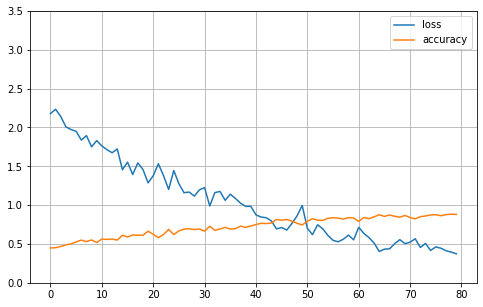

In [26]:
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3.5)
plt.show()